In [1]:
import random
from math import sin, cos, pi, exp, e, sqrt
from operator import mul
from functools import reduce

from deap import base, creator, tools, algorithms, benchmarks 

import numpy as np
import autograd.numpy as anp
import pandas as pd

import pymop
from deap.benchmarks.tools import diversity, convergence, hypervolume

import csv
import time, array

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from math import factorial

In [2]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [3]:
def measure_time(x):
    execution_time = time.time() - start_time 
    return execution_time

In [4]:
def nsga_ii(toolbox, seed, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    random.seed(seed)
    return algorithms.eaMuPlusLambda(pop, 
                                     toolbox, 
                                     mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=toolbox.cross_prob,
                                     mutpb=toolbox.mut_prob,
                                     ngen=toolbox.max_gen,
                                     stats=stats, 
                                     verbose=verbose)

In [5]:
def nsga_iii(toolbox,stats,logbook,NGEN,MU,CXPB,MUTPB,verbose=False):
    pop = toolbox.population(n=MU)
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
#   fitnesses = toolbox.map(toolbox.evaluate, pop)        
#     for ind, fit in zip(pop, fitnesses):
#         ind.fitness.values = fit
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop = toolbox.select(pop, len(pop))
    
    # Begin the generational process
    for gen in range(1, NGEN):
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        record = stats.compile(pop) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
        if verbose:
            print(logbook.stream)
        
        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
    
    return pop, logbook

In [6]:
def zdt1(individual):
    g = 1.0 + 9.0 * sum(individual[1:]) / (len(individual) - 1)
    f1 = individual[0]
    f2 = g * (1 - sqrt(f1 / g))
    return f1, f2

In [7]:
def zdt2(individual):
    g = 1.0 + 9.0 * sum(individual[1:]) / (len(individual) - 1)
    f1 = individual[0]
    f2 = g * (1 - (f1 / g)**2)
    return f1, f2

In [8]:
def zdt3(individual):
    g = 1.0 + 9.0 * sum(individual[1:]) / (len(individual) - 1)
    f1 = individual[0]
    f2 = g * (1 - sqrt(f1 / g) - f1 / g * sin(10 * pi * f1))
    return f1, f2

In [9]:
def zdt4(individual):
    g = 1 + 10 * (len(individual) - 1) + sum(xi**2 - 10 * cos(4 * pi * xi) for xi in individual[1:])
    f1 = individual[0]
    f2 = g * (1 - sqrt(f1 / g))
    return f1, f2

In [10]:
def zdt5(individual, m=11, n=5, normal=True):
    if len(individual) % 5 != 0 and len(x) < 35:
        raise ValueError("Bit vector's length must contain at least 35 digits.")

    x1 = individual[:30]
    xm = individual[30:]

    g = 0

    def vu(v):
        if v < 5:
            x = 2 + v
        elif v == 5:
            x = 1
        return x

    for i in range(m):
        x = sum(xm[(n * (i - 1)):(n * i)])
        v = vu(x)
        g += v

    f1 = 1 + sum(np.array(x1) == 1)
    f2 = g * (1 / f1)

    def normalize(x, x_min, x_max):
        denom = x_max - x_min
        denom += 1e-30
        N = (x - x_min) / denom
        return N

    if normal:
        f1 = normalize(f1, 1, 30)
        f2 = normalize(f2, (m - 1) * 1 / 30, (m - 1))

    return f1, f2

In [11]:
def zdt6(individual):
    g = 1 + 9 * (sum(individual[1:]) / (len(individual) - 1))**0.25
    f1 = 1 - exp(-4 * individual[0]) * sin(6 * pi * individual[0])**6
    f2 = g * (1 - (f1 / g)**2)
    return f1, f2

In [12]:
NOBJ = 2
BOUND_LOW, BOUND_UP = 0.0, 1.0
MU = 100
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

P = 99
ref_points = tools.uniform_reference_points(NOBJ, P)

seed = 1

## ZDT 1

In [60]:
NDIM = 3
creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", zdt1) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

# stats = tools.Statistics()

In [61]:
start_time = time.time()
res, logbook = nsga_ii(toolbox=toolbox, seed=1, stats=stats, verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga2_zdt1_100_500_2_3.csv', index=False)

gen	nevals	avg    	std   	min       	max   	time      
0  	100   	2.25022	2.1423	0.00755541	8.1057	0.00402546
1  	100   	1.78906	1.89932	0.00755541	7.83578	0.101727  
2  	100   	1.47601	1.62306	0.00755541	6.83961	0.151659  
3  	100   	1.36571	1.69356	0.00755541	7.05606	0.186536  
4  	100   	1.25788	1.73474	0.00755541	6.88658	0.219414  
5  	100   	0.906446	1.17478	0.0021529 	7.03688	0.252361  
6  	100   	0.73517 	0.93997	0.0021529 	7.03688	0.285238  
7  	100   	0.631226	0.815985	0.000205734	7.1483 	0.313162  
8  	100   	0.647825	1.01838 	0.000205734	7.17782	0.356049  
9  	100   	0.592467	0.82095 	0.000205734	7.14944	0.393948  
10 	100   	0.503062	0.45796 	0.000205734	3.49808	0.431843  
11 	100   	0.488617	0.417616	0.000205734	1.98108	0.465753  
12 	100   	0.457608	0.341434	0.000205734	1.28742	0.500659  
13 	100   	0.446669	0.333606	0.000205734	1.0927 	0.533624  
14 	100   	0.442918	0.339035	0.000205734	1.0927 	0.559595  
15 	100   	0.437953	0.326848	2.92101e-05	1.0927 	0.587516  
16 	10

140	100   	0.417962	0.292921	3.36714e-08	0.999999	4.96726   
141	100   	0.41712 	0.296302	3.36714e-08	0.999999	5.01014   
142	100   	0.418266	0.301473	3.36714e-08	0.999999	5.05203   
143	100   	0.418224	0.298399	3.36714e-08	0.999999	5.08594   
144	100   	0.419842	0.304149	3.36714e-08	0.999999	5.11586   
145	100   	0.41907 	0.300514	3.36714e-08	0.999999	5.15376   
146	100   	0.419773	0.301125	3.36714e-08	0.999999	5.18667   
147	100   	0.41613 	0.29439 	3.36714e-08	0.999999	5.22162   
148	100   	0.419169	0.303506	3.36714e-08	0.999999	5.25552   
149	100   	0.418734	0.299153	3.36714e-08	0.999999	5.2884    
150	100   	0.420048	0.301745	3.36714e-08	0.999999	5.32231   
151	100   	0.418687	0.306244	3.36714e-08	0.999999	5.35921   
152	100   	0.417488	0.29346 	3.36714e-08	0.999999	5.39312   
153	100   	0.418027	0.296081	3.36714e-08	0.999999	5.42703   
154	100   	0.420401	0.308508	3.36714e-08	0.999999	5.46094   
155	100   	0.422053	0.308035	3.36714e-08	0.999999	5.49385   
156	100   	0.417793	0.29

277	100   	0.420928	0.30552 	7.55385e-10	1       	10.4996   
278	100   	0.419614	0.30179 	7.55385e-10	1       	10.5355   
279	100   	0.418655	0.296343	7.55385e-10	1       	10.5744   
280	100   	0.419248	0.298429	7.55385e-10	1       	10.6276   
281	100   	0.421126	0.30655 	7.55385e-10	1       	10.6665   
282	100   	0.421009	0.304633	7.55385e-10	1       	10.6934   
283	100   	0.418801	0.297783	7.55385e-10	1       	10.7253   
284	100   	0.419087	0.30055 	7.55385e-10	1       	10.7692   
285	100   	0.421028	0.309447	7.55385e-10	1       	10.8211   
286	100   	0.420267	0.306849	7.55385e-10	1       	10.855    
287	100   	0.419376	0.302393	7.55385e-10	1       	10.8909   
288	100   	0.419439	0.29829 	7.55385e-10	1       	10.9208   
289	100   	0.419087	0.307602	4.05552e-10	1       	10.9547   
290	100   	0.418698	0.304039	4.05552e-10	1       	10.9837   
291	100   	0.419245	0.303062	4.05552e-10	1       	11.0166   
292	100   	0.420849	0.303444	4.05552e-10	1       	11.0565   
293	100   	0.419462	0.30

417	100   	0.418717	0.298873	5.55653e-11	1       	15.4495   
418	100   	0.42147 	0.311022	5.55653e-11	1       	15.4774   
419	100   	0.420943	0.302271	1.89605e-11	1       	15.5073   
420	100   	0.418014	0.297035	1.89605e-11	1       	15.5352   
421	100   	0.419698	0.298522	1.89605e-11	1       	15.5712   
422	100   	0.422008	0.311253	1.89605e-11	1       	15.5991   
423	100   	0.4204  	0.303576	1.89605e-11	1       	15.641    
424	100   	0.420302	0.302513	7.03974e-12	1       	15.6858   
425	100   	0.417767	0.294355	7.03974e-12	1       	15.7297   
426	100   	0.419429	0.295646	7.03974e-12	1       	15.7577   
427	100   	0.420197	0.303021	7.03974e-12	1       	15.7856   
428	100   	0.413943	0.280762	7.03974e-12	1       	15.8155   
429	100   	0.419498	0.301955	7.03974e-12	1       	15.8444   
430	100   	0.420889	0.302015	7.03974e-12	1       	15.8883   
431	100   	0.417164	0.289655	7.03974e-12	1       	15.9212   
432	100   	0.415651	0.28541 	7.03974e-12	1       	15.9501   
433	100   	0.419078	0.29

In [64]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_zdt1_100_500_2_3.csv', index=False)

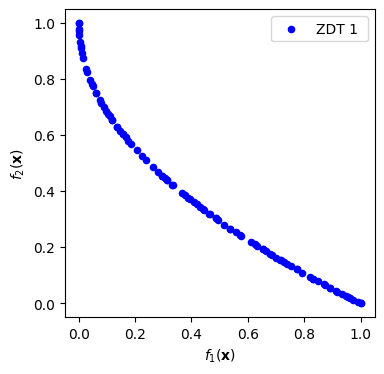

In [62]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 1 ', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [65]:
NDIM = 3

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", zdt1) #Fitness Function
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [66]:
start_time = time.time()
res, logbook = nsga_iii(toolbox=toolbox,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_zdt1_100_500_2_3.csv', index=False)

gen	evals	std    	min       	avg    	max    	time     
1  	     	2.08425	0.00404362	2.25942	7.29759	0.0692244
2  	     	1.80168	0.00121585	1.81332	7.02739	0.138621 
3  	     	1.65235	0.00121585	1.53389	6.17619	0.281403 
4  	     	1.30363	0.00121585	1.1959 	5.40289	0.287387 
5  	     	0.772922	0.00121585	0.817745	4.19536	0.298358 
6  	     	0.584219	0.00121585	0.667221	2.0627 	0.308332 
7  	     	0.576058	0.000844603	0.631121	1.52001	0.3203   
8  	     	0.523121	0.000540515	0.612755	1.74018	0.331279 
9  	     	0.479668	0.000540515	0.575754	1.74018	0.339288 
10 	     	0.462392	0.000540515	0.567747	1.74018	0.348226 
11 	     	0.493413	0.000540515	0.552351	1.53454	0.355206 
12 	     	0.54002 	0.000540515	0.568306	1.53454	0.367174 
13 	     	0.448383	0.000432868	0.509415	1.25811	0.389117 
14 	     	0.399509	0.000362538	0.486666	1.68926	0.396098 
15 	     	0.453952	0.000362538	0.491215	1.68926	0.402081 
16 	     	0.466007	0.000362538	0.502097	1.76466	0.407067 
17 	     	0.460624	0.000362538	

158	     	0.255223	2.39765e-05	0.40791 	0.999783	1.8371   
159	     	0.255241	2.39765e-05	0.407916	0.999783	1.84608  
160	     	0.255243	2.39765e-05	0.407918	0.999783	1.85705  
161	     	0.255324	2.39765e-05	0.407938	0.999783	1.86702  
162	     	0.255326	2.39765e-05	0.407934	0.999783	1.874    
163	     	0.255329	2.39765e-05	0.407934	0.999783	1.88497  
164	     	0.255364	2.39765e-05	0.40794 	0.999783	1.89295  
165	     	0.255366	2.39765e-05	0.407941	0.999783	1.90392  
166	     	0.255367	2.39765e-05	0.407942	0.999783	1.91589  
167	     	0.255414	2.39765e-05	0.40795 	0.999783	1.92387  
168	     	0.255414	2.39765e-05	0.40795 	0.999783	1.93185  
169	     	0.255392	2.39765e-05	0.407946	0.999783	1.94182  
170	     	0.25539 	2.39765e-05	0.407945	0.999783	1.9498   
171	     	0.255391	2.39765e-05	0.407945	0.999783	1.95678  
172	     	0.255406	2.39765e-05	0.407948	0.999783	1.96675  
173	     	0.25542 	2.39765e-05	0.407951	0.999783	1.97373  
174	     	0.25542 	2.39765e-05	0.407951	0.999783	1.98072

300	     	0.255364	2.20427e-06	0.407931	0.999996	3.15529  
301	     	0.255363	2.20427e-06	0.40793 	0.999996	3.16926  
302	     	0.255358	2.20427e-06	0.407929	0.999996	3.18222  
303	     	0.255368	1.5557e-07 	0.407933	0.999996	3.18929  
304	     	0.255365	1.5557e-07 	0.407932	0.999996	3.20126  
305	     	0.255357	1.5557e-07 	0.407928	0.999996	3.20923  
306	     	0.255356	1.5557e-07 	0.407927	0.999996	3.21921  
307	     	0.25536 	1.5557e-07 	0.407927	0.999996	3.22519  
308	     	0.255367	1.5557e-07 	0.407927	0.999996	3.23417  
309	     	0.255391	1.5557e-07 	0.407933	0.999996	3.24115  
310	     	0.25541 	1.5557e-07 	0.407936	0.999996	3.2909   
311	     	0.255412	1.5557e-07 	0.407936	0.999996	3.30287  
312	     	0.255411	1.5557e-07 	0.407935	0.999996	3.30985  
313	     	0.255411	1.5557e-07 	0.407934	0.999996	3.31982  
314	     	0.255424	1.5557e-07 	0.407937	0.999996	3.3268   
315	     	0.255422	4.397e-08  	0.407936	0.999996	3.33777  
316	     	0.255425	4.397e-08  	0.407936	0.999996	3.34475

449	     	0.257872	4.97396e-09	0.406411	1.43939 	4.73237  
450	     	0.25718 	4.97396e-09	0.406319	1.43939 	4.74234  
451	     	0.261159	4.97396e-09	0.407042	1.43939 	4.7583   
452	     	0.259803	3.04609e-09	0.406468	1.43939 	4.77525  
453	     	0.258666	4.3836e-10 	0.406489	1.43939 	4.78922  
454	     	0.261891	4.3836e-10 	0.407569	1.43939 	4.80172  
455	     	0.258645	4.3836e-10 	0.406552	1.43939 	4.81569  
456	     	0.260791	4.3836e-10 	0.406672	1.43939 	4.82565  
457	     	0.261003	4.3836e-10 	0.406714	1.43939 	4.83762  
458	     	0.263416	4.3836e-10 	0.407495	1.43939 	4.8476   
459	     	0.26108 	4.3836e-10 	0.406686	1.43939 	4.85757  
460	     	0.264625	4.38359e-10	0.407723	1.43939 	4.87053  
461	     	0.262558	4.38359e-10	0.406854	1.43939 	4.88549  
462	     	0.261613	4.38359e-10	0.406713	1.43947 	4.90943  
463	     	0.26165 	4.38359e-10	0.406724	1.43947 	4.9204   
464	     	0.26169 	4.38359e-10	0.406734	1.43947 	4.92938  
465	     	0.261742	4.38359e-10	0.406751	1.43947 	4.93935

In [68]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_zdt1_100_500_2_3.csv', index=False)

## ZDT 2

In [19]:
NDIM = 4

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()
toolbox.register("evaluate", zdt2) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("avg", np.mean)
# stats.register("std", np.std)
# stats.register("min", np.min)
# stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
# logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"
logbook.header = "gen", "evals", "time"

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [20]:
start_time = time.time()
res, logbook = nsga_ii(toolbox=toolbox, seed=1, stats=stats, verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga2_zdt2_100_500_2_4.csv', index=False)

gen	nevals	time      
0  	100   	0.00997114
1  	100   	0.145653  
2  	100   	0.21043   
3  	100   	0.270271  
4  	100   	0.331108  
5  	100   	0.377026  
6  	100   	0.443078  
7  	100   	0.497707  
8  	100   	0.555576  
9  	100   	0.618407  
10 	100   	0.67131   
11 	100   	0.733105  
12 	100   	0.792941  
13 	100   	0.857768  
14 	100   	0.907016  
15 	100   	0.965866  
16 	100   	1.03663   
17 	100   	1.09404   
18 	100   	1.17981   
19 	100   	1.24096   
20 	100   	1.29586   
21 	100   	1.34872   
22 	100   	1.38462   
23 	100   	1.42157   
24 	100   	1.48236   
25 	100   	1.53821   
26 	100   	1.59462   
27 	100   	1.6744    
28 	100   	1.74824   
29 	100   	1.82703   
30 	100   	1.89446   
31 	100   	1.9782    
32 	100   	2.06055   
33 	100   	2.13889   
34 	100   	2.20372   
35 	100   	2.27652   
36 	100   	2.34159   
37 	100   	2.39944   
38 	100   	2.48321   
39 	100   	2.54911   
40 	100   	2.62095   
41 	100   	2.67477   
42 	100   	2.72773   
43 	100   	2.78651   
44 	100   

376	100   	23.0183   
377	100   	23.0691   
378	100   	23.1211   
379	100   	23.1759   
380	100   	23.2257   
381	100   	23.2776   
382	100   	23.3424   
383	100   	23.4018   
384	100   	23.4866   
385	100   	23.5524   
386	100   	23.6339   
387	100   	23.7227   
388	100   	23.7945   
389	100   	23.8484   
390	100   	23.9112   
391	100   	23.9721   
392	100   	24.0359   
393	100   	24.0938   
394	100   	24.1486   
395	100   	24.2014   
396	100   	24.2563   
397	100   	24.3274   
398	100   	24.3863   
399	100   	24.4651   
400	100   	24.533    
401	100   	24.5958   
402	100   	24.6566   
403	100   	24.7066   
404	100   	24.7624   
405	100   	24.8142   
406	100   	24.8661   
407	100   	24.928    
408	100   	24.9788   
409	100   	25.0397   
410	100   	25.0935   
411	100   	25.1444   
412	100   	25.1982   
413	100   	25.2491   
414	100   	25.3157   
415	100   	25.3746   
416	100   	25.4305   
417	100   	25.4934   
418	100   	25.5483   
419	100   	25.6001   
420	100   	25.659    
421	100   

In [21]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_zdt2_100_500_2_4.csv', index=False)

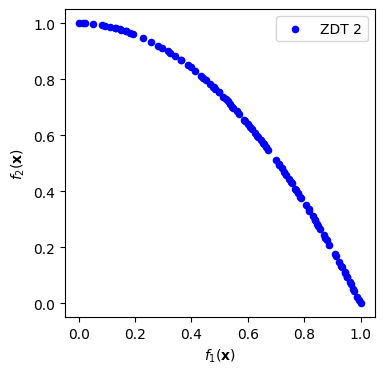

In [71]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 2', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [16]:
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

In [17]:
start_time = time.time()
res, logbook = nsga_iii(toolbox=toolbox,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_zdt2_100_500_2_4.csv', index=False)

gen	evals	std    	min       	avg    	max   	time    
1  	     	2.73978	0.00496109	3.00604	8.3824	0.799292
2  	     	2.28515	0.00496109	2.41321	8.26913	0.851484
3  	     	2.00292	0.0048376 	2.03347	6.41648	0.867484
4  	     	1.80011	0.00442138	1.79121	6.39461	0.880893
5  	     	1.54916	0.00210908	1.58189	5.67759	0.888893
6  	     	1.31392	0.00210908	1.39022	5.67759	0.896893
7  	     	1.29435	0.000812252	1.304  	5.67759	0.904894
8  	     	1.29949	0.000812252	1.2247 	5.67759	0.91543 
9  	     	1.13635	0.000812252	1.07207	4.73146	0.927437
10 	     	1.29025	0.000645709	1.18959	4.73146	0.939429
11 	     	1.22736	0.000431173	1.1026 	4.2591 	0.94743 
12 	     	1.20349	0.000431173	1.05237	4.33242	0.959429
13 	     	1.09176	0.000423419	0.977198	3.74894	0.96743 
14 	     	0.925229	0.000423419	0.858403	2.84425	0.97943 
15 	     	0.753853	0.000285325	0.767798	2.84424	0.991429
16 	     	0.627327	0.00017793 	0.697215	2.79251	0.998741
17 	     	0.644927	0.00017793 	0.704322	3.0572 	1.01238 
18 	     	

148	     	0.319165	1.09275e-06	0.575284	1      	2.57887 
149	     	0.319163	1.09275e-06	0.575283	1      	2.5865  
150	     	0.31917 	1.09275e-06	0.575282	1      	2.59794 
151	     	0.319173	1.09275e-06	0.575281	1      	2.61104 
152	     	0.319174	1.09275e-06	0.57528 	1      	2.62332 
153	     	0.319175	1.09275e-06	0.57528 	1      	2.63589 
154	     	0.319175	1.09275e-06	0.57528 	1      	2.64461 
155	     	0.319175	1.09275e-06	0.57528 	1      	2.65666 
156	     	0.319175	1.09275e-06	0.57528 	1      	2.66866 
157	     	0.319176	1.09275e-06	0.57528 	1      	2.68066 
158	     	0.320929	1.66513e-07	0.576338	1.21171	2.70062 
159	     	0.322736	1.66513e-07	0.576344	1.21171	2.71125 
160	     	0.317028	1.66513e-07	0.576929	1.01659	2.7273  
161	     	0.316493	1.66513e-07	0.576214	1.01659	2.74108 
162	     	0.319241	1.66513e-07	0.575608	1.01659	2.75308 
163	     	0.319799	1.66513e-07	0.575254	1.01659	2.76508 
164	     	0.319597	1.66513e-07	0.575677	1.01659	2.78108 
165	     	0.320074	1.66513e-07	

304	     	0.319263	2.80483e-09	0.575257	1      	4.55715 
305	     	0.319263	2.80483e-09	0.575257	1      	4.56604 
306	     	0.319263	2.80483e-09	0.575257	1      	4.57755 
307	     	0.319263	2.80483e-09	0.575257	1      	4.59333 
308	     	0.319263	2.80483e-09	0.575257	1      	4.6034  
309	     	0.319263	2.80483e-09	0.575257	1      	4.61933 
310	     	0.319262	8.12023e-10	0.575258	1      	4.63133 
311	     	0.319262	8.12023e-10	0.575258	1      	4.64329 
312	     	0.319262	8.12023e-10	0.575258	1      	4.65534 
313	     	0.319262	8.12023e-10	0.575258	1      	4.66733 
314	     	0.319262	8.12023e-10	0.575258	1      	4.67933 
315	     	0.319262	8.12023e-10	0.575258	1      	4.69134 
316	     	0.319265	8.12023e-10	0.575256	1      	4.70543 
317	     	0.319269	8.12023e-10	0.575255	1      	4.71819 
318	     	0.319269	8.12023e-10	0.575255	1      	4.73819 
319	     	0.319269	8.12023e-10	0.575255	1      	4.75019 
320	     	0.319265	8.12023e-10	0.575257	1      	4.76219 
321	     	0.319265	8.12023e-10	

465	     	0.319268	2.06266e-10	0.575255	1      	6.5435  
466	     	0.319269	2.06266e-10	0.575255	1      	6.55572 
467	     	0.319269	2.06266e-10	0.575255	1      	6.5698  
468	     	0.319269	2.06266e-10	0.575255	1      	6.57797 
469	     	0.319269	2.06266e-10	0.575255	1      	6.5945  
470	     	0.319269	2.06266e-10	0.575255	1      	6.61621 
471	     	0.319269	2.06266e-10	0.575255	1      	6.61621 
472	     	0.319269	2.06266e-10	0.575255	1      	6.64746 
473	     	0.319268	2.06266e-10	0.575255	1      	6.66312 
474	     	0.319268	2.06266e-10	0.575255	1      	6.66312 
475	     	0.319268	2.06266e-10	0.575255	1      	6.67981 
476	     	0.319268	2.06266e-10	0.575255	1      	6.69551 
477	     	0.319268	2.06266e-10	0.575255	1      	6.69551 
478	     	0.319269	2.06266e-10	0.575255	1      	6.71835 
479	     	0.319268	2.06266e-10	0.575255	1      	6.72853 
480	     	0.319269	2.06266e-10	0.575255	1      	6.73869 
481	     	0.319269	2.06266e-10	0.575255	1      	6.76114 
482	     	0.319269	2.06266e-10	

In [18]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_zdt2_100_500_2_4.csv', index=False)

## ZDT 3

In [79]:
NDIM = 5

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", zdt3) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [81]:
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

In [82]:
start_time = time.time()
res, logbook = nsga_ii(toolbox=toolbox, seed=1, stats=stats, verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga2_zdt3_100_500_2_5.csv', index=False)

gen	nevals	avg    	std    	min       	max    	time      
0  	100   	2.21328	1.90198	0.00234726	6.49466	0.00498629
1  	100   	1.83324	1.70188	0.00234726	6.41208	0.0687928 
2  	100   	1.71939	1.79031	0.00234726	6.34341	0.111701  
3  	100   	1.61098	1.76683	-0.216229 	6.34341	0.152525  
4  	100   	1.41609	1.62714	-0.216229 	6.34341	0.190975  
5  	100   	1.22861	1.46253	-0.308687 	5.93757	0.23087   
6  	100   	1.04579	1.30405	-0.379298 	5.95507	0.267813  
7  	100   	0.92312	1.15716	-0.379298 	5.93757	0.315643  
8  	100   	0.839153	0.982424	-0.379298 	5.11758	0.35055   
9  	100   	0.749598	0.889528	-0.514782 	4.05565	0.387451  
10 	100   	0.759494	0.94295 	-0.514782 	4.05565	0.432329  
11 	100   	0.668821	0.889605	-0.514782 	4.05565	0.486185  
12 	100   	0.599288	0.821905	-0.514782 	4.05565	0.528073  
13 	100   	0.590051	0.829507	-0.548825 	4.05565	0.56697   
14 	100   	0.520218	0.693592	-0.548825 	4.05565	0.604868  
15 	100   	0.47175 	0.588546	-0.548825 	3.18967	0.645799  
16 	100   	0.42

146	100   	0.269182	0.425454	-0.773305 	0.999171	5.85791   
147	100   	0.26331 	0.41589 	-0.773305 	0.999171	5.91176   
148	100   	0.272683	0.413599	-0.773305 	0.999171	5.94563   
149	100   	0.263875	0.425696	-0.773305 	0.999171	5.98154   
150	100   	0.270193	0.437404	-0.773305 	0.999171	6.01548   
151	100   	0.266523	0.444701	-0.773324 	0.999171	6.05135   
152	100   	0.26568 	0.438223	-0.773324 	0.999171	6.09922   
153	100   	0.263684	0.436826	-0.773324 	0.999171	6.14813   
154	100   	0.262592	0.442228	-0.773324 	0.999171	6.18699   
155	100   	0.263872	0.442022	-0.773324 	0.999171	6.22692   
156	100   	0.268363	0.4503  	-0.773349 	0.999171	6.26183   
157	100   	0.271025	0.424866	-0.773349 	0.999171	6.30272   
158	100   	0.265039	0.433402	-0.773349 	0.999171	6.34358   
159	100   	0.271256	0.420902	-0.773349 	0.999171	6.37952   
160	100   	0.268101	0.42327 	-0.773349 	0.999171	6.42092   
161	100   	0.269523	0.431745	-0.773349 	0.999171	6.45878   
162	100   	0.266557	0.427669	-0.773349 	

284	100   	0.265717	0.429041	-0.773369 	0.9995  	11.895    
285	100   	0.260422	0.443478	-0.773369 	0.9995  	11.9408   
286	100   	0.266481	0.433041	-0.773369 	0.9995  	11.9797   
287	100   	0.263172	0.450794	-0.773369 	0.9995  	12.0196   
288	100   	0.265831	0.437395	-0.773369 	0.9995  	12.0635   
289	100   	0.267992	0.441237	-0.773369 	0.9995  	12.1134   
290	100   	0.260974	0.447916	-0.773369 	1.08982 	12.1512   
291	100   	0.2562  	0.447085	-0.773369 	1.08982 	12.1911   
292	100   	0.26099 	0.442882	-0.773369 	1.08982 	12.236    
293	100   	0.26274 	0.445212	-0.773369 	1.08982 	12.2789   
294	100   	0.274116	0.426644	-0.773369 	1.08982 	12.3238   
295	100   	0.281111	0.411949	-0.773369 	1.08982 	12.3702   
296	100   	0.272204	0.414371	-0.773369 	1.08982 	12.42     
297	100   	0.270755	0.422557	-0.773369 	1.08982 	12.4852   
298	100   	0.265527	0.441849	-0.773369 	1.08982 	12.5505   
299	100   	0.269658	0.440025	-0.773369 	1.08982 	12.6004   
300	100   	0.269764	0.439888	-0.773369 	

425	100   	0.276403	0.436192	-0.773369 	1.16758 	18.082    
426	100   	0.271142	0.440563	-0.773369 	1.16758 	18.1199   
427	100   	0.269998	0.437788	-0.773369 	1.02205 	18.1588   
428	100   	0.268193	0.430059	-0.773369 	1.00864 	18.2017   
429	100   	0.271277	0.422932	-0.773369 	1.00864 	18.2376   
430	100   	0.266971	0.424946	-0.773369 	1.00864 	18.2905   
431	100   	0.262598	0.430568	-0.773369 	1.00864 	18.3234   
432	100   	0.2644  	0.42699 	-0.773369 	1.00006 	18.3643   
433	100   	0.261329	0.427884	-0.773369 	1.00006 	18.3982   
434	100   	0.268927	0.42965 	-0.773369 	1.00006 	18.4391   
435	100   	0.263742	0.43253 	-0.773369 	0.999886	18.485    
436	100   	0.26803 	0.434267	-0.773369 	0.999886	18.5298   
437	100   	0.261595	0.447618	-0.773369 	0.999881	18.5697   
438	100   	0.262302	0.444168	-0.773369 	0.99984 	18.6161   
439	100   	0.257116	0.445376	-0.773369 	0.99984 	18.657    
440	100   	0.269537	0.440225	-0.773369 	0.999839	18.6889   
441	100   	0.268689	0.438402	-0.773369 	

In [84]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_zdt3_100_500_2_5.csv', index=False)

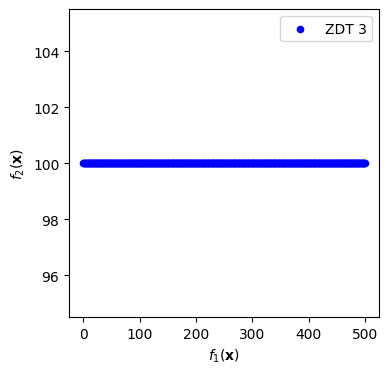

In [85]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 3', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [86]:
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

In [87]:
start_time = time.time()
res, logbook = nsga_iii(toolbox=toolbox,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_zdt3_100_500_2_5.csv', index=False)

gen	evals	std    	min       	avg    	max    	time     
1  	     	1.95727	0.00554082	2.23478	6.66283	0.0139625
2  	     	1.83191	0.00554082	1.91064	6.37741	0.0239356
3  	     	1.8556 	0.00553445	1.77983	6.24842	0.0398922
4  	     	1.75583	0.00553445	1.63932	5.97024	0.0518601
5  	     	1.73842	0.00547488	1.5821 	5.97024	0.082649 
6  	     	1.55901	0.00338513	1.40897	5.75064	0.0876737
7  	     	1.6415 	0.00338513	1.42041	5.75064	0.0926573
8  	     	1.55424	0.00338199	1.31126	4.79387	0.098644 
9  	     	1.4205 	0.00218095	1.18346	5.34101	0.103633 
10 	     	1.11601	0.00218095	0.968432	5.34101	0.110575 
11 	     	0.810086	0.00218095	0.804067	3.5428 	0.118593 
12 	     	0.749028	-0.186073 	0.759284	3.51682	0.12261  
13 	     	0.548623	-0.186073 	0.651744	2.05258	0.128528 
14 	     	0.436803	-0.186073 	0.589876	1.89542	0.133513 
15 	     	0.442593	-0.186073 	0.560951	1.65406	0.139535 
16 	     	0.448883	-0.186073 	0.532382	1.62384	0.148539 
17 	     	0.435921	-0.197068 	0.504732	1.5502 	0.152

154	     	0.324413	-0.458228 	0.280421	0.999307	1.32397  
155	     	0.324259	-0.458228 	0.286448	0.999307	1.33295  
156	     	0.3322  	-0.458228 	0.287702	0.999307	1.34196  
157	     	0.332339	-0.476306 	0.280291	0.999307	1.3509   
158	     	0.338234	-0.476306 	0.287339	0.999307	1.35888  
159	     	0.334853	-0.476306 	0.287194	0.999307	1.3659   
160	     	0.34456 	-0.476306 	0.282919	0.999307	1.37188  
161	     	0.348552	-0.599317 	0.281721	0.999307	1.38281  
162	     	0.342554	-0.599317 	0.283901	0.999307	1.39578  
163	     	0.342444	-0.599317 	0.284012	0.999307	1.41273  
164	     	0.357389	-0.602713 	0.284611	0.999307	1.41972  
165	     	0.364392	-0.671127 	0.283409	0.999307	1.4257   
166	     	0.360228	-0.671127 	0.280722	0.999307	1.43168  
167	     	0.36579 	-0.671127 	0.278347	0.999307	1.44066  
168	     	0.38042 	-0.763874 	0.275571	0.999307	1.45263  
169	     	0.382552	-0.763876 	0.268325	0.999307	1.45861  
170	     	0.38938 	-0.763876 	0.264685	0.999302	1.46559  
171	     	0.41

316	     	0.436507	-0.773369 	0.254134	0.999751	2.64117  
317	     	0.431496	-0.773369 	0.252622	0.999751	2.65214  
318	     	0.416686	-0.773369 	0.259947	0.999751	2.6671   
319	     	0.42316 	-0.773369 	0.260531	0.999751	2.67608  
320	     	0.425791	-0.773369 	0.263992	0.999751	2.68605  
321	     	0.426912	-0.773369 	0.265159	0.999751	2.69304  
322	     	0.422509	-0.773369 	0.265442	0.999751	2.70001  
323	     	0.423643	-0.773369 	0.270186	0.999751	2.70703  
324	     	0.416863	-0.773369 	0.264505	0.999751	2.71597  
325	     	0.434452	-0.773369 	0.263052	0.999751	2.72295  
326	     	0.424021	-0.773369 	0.261377	0.999751	2.73093  
327	     	0.441737	-0.773369 	0.254838	0.999751	2.73795  
328	     	0.430905	-0.773369 	0.255808	0.999751	2.74789  
329	     	0.438107	-0.773369 	0.260264	0.999751	2.75587  
330	     	0.432874	-0.773369 	0.258112	0.999751	2.76288  
331	     	0.438839	-0.773369 	0.256363	0.999751	2.76983  
332	     	0.432648	-0.773369 	0.25935 	0.999751	2.77984  
333	     	0.42

463	     	0.466489	-0.773369 	0.238041	1.01274 	3.96118  
464	     	0.448634	-0.773369 	0.249832	1.01274 	3.97115  
465	     	0.468343	-0.773369 	0.229148	1.01274 	3.98511  
466	     	0.444507	-0.773369 	0.240594	1.01274 	3.9921   
467	     	0.453366	-0.773369 	0.239756	1.01274 	4.00107  
468	     	0.45439 	-0.773369 	0.241218	1.01274 	4.00805  
469	     	0.450937	-0.773369 	0.239129	1.00022 	4.01903  
470	     	0.448964	-0.773369 	0.241167	1.00022 	4.026    
471	     	0.460587	-0.773369 	0.241083	1.00022 	4.03398  
472	     	0.467927	-0.773369 	0.24369 	1.00022 	4.04027  
473	     	0.470848	-0.773369 	0.240178	1.00022 	4.05124  
474	     	0.48153 	-0.773369 	0.228766	0.99977 	4.05922  
475	     	0.463822	-0.773369 	0.24306 	0.99977 	4.0672   
476	     	0.465564	-0.773369 	0.232216	0.99977 	4.07418  
477	     	0.462343	-0.773369 	0.235801	0.99977 	4.08316  
478	     	0.467828	-0.773369 	0.233972	0.99977 	4.09114  
479	     	0.472148	-0.773369 	0.234733	0.99977 	4.09912  
480	     	0.45

In [89]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_zdt3_100_500_2_5.csv', index=False)

## ZDT 4

In [90]:
NDIM = 7

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", zdt4) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [91]:
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

In [92]:
start_time = time.time()
res, logbook = nsga_ii(toolbox=toolbox, seed=1, stats=stats, verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga2_zdt4_100_500_2_7.csv', index=False)

gen	nevals	avg    	std    	min      	max    	time      
0  	100   	29.1513	31.0621	0.0259757	99.7113	0.00601912
1  	100   	23.6272	25.8123	0.0257348	87.3204	0.112006  
2  	100   	19.9054	22.6032	0.0206222	84.0289	0.199919  
3  	100   	17.7389	20.7707	0.00815291	85.0133	0.275199  
4  	100   	14.0414	17.2128	0.0044842 	85.0133	0.350069  
5  	100   	11.1444	14.8875	0.000356228	85.675 	0.425189  
6  	100   	9.08869	13.5971	0.000356228	85.675 	0.51388   
7  	100   	6.34097	8.98226	0.000356228	85.675 	0.594308  
8  	100   	5.63735	8.40829	0.000356228	85.675 	0.661155  
9  	100   	5.62703	10.1642	0.000356228	85.675 	0.746875  
10 	100   	6.32381	13.714 	0.000356228	88.2445	0.817545  
11 	100   	6.91431	16.4138	0.000328461	85.7167	0.90051   
12 	100   	5.90593	13.0958	4.65641e-06	85.5847	0.973853  
13 	100   	4.00795	8.13792	4.65641e-06	85.5847	1.04497   
14 	100   	3.68751	6.42112	4.65641e-06	50.0478	1.12321   
15 	100   	3.13011	5.26006	4.65641e-06	32.4326	1.20822   
16 	100   	3.05315	5.381

139	100   	0.503822	0.316036	4.53787e-12	1.2497 	9.96583   
140	100   	0.503752	0.31219 	1.92374e-12	1.2497 	10.0198   
141	100   	0.504114	0.315911	1.92374e-12	1.2497 	10.0829   
142	100   	0.501665	0.308761	1.92374e-12	1.2497 	10.1496   
143	100   	0.501733	0.312645	1.92374e-12	1.24969	10.2234   
144	100   	0.506762	0.32345 	1.92374e-12	1.24969	10.2878   
145	100   	0.504148	0.308398	1.92374e-12	1.24968	10.3558   
146	100   	0.50538 	0.32174 	1.92374e-12	1.24968	10.4221   
147	100   	0.506675	0.330386	1.92374e-12	1.24968	10.5121   
148	100   	0.503675	0.309433	1.92374e-12	1.24968	10.597    
149	100   	0.503474	0.30649 	1.92374e-12	1.24968	10.6612   
150	100   	0.501084	0.300457	1.92374e-12	1.24968	10.7411   
151	100   	0.502393	0.305387	1.92374e-12	1.24968	10.8128   
152	100   	0.505197	0.326668	1.92374e-12	1.24968	10.8745   
153	100   	0.503355	0.31563 	1.92374e-12	1.24968	10.94     
154	100   	0.50369 	0.317627	1.92374e-12	1.24968	11.0169   
155	100   	0.503197	0.307179	1.92374e-12

276	100   	0.507094	0.319734	4.22048e-13	1.24968	19.3376   
277	100   	0.507766	0.317087	4.22048e-13	1.24968	19.4034   
278	100   	0.509546	0.330402	4.22048e-13	1.24968	19.467    
279	100   	0.508225	0.316058	4.22048e-13	1.24968	19.5269   
280	100   	0.509106	0.319871	4.22048e-13	1.24968	19.5894   
281	100   	0.511173	0.332956	4.22048e-13	1.24968	19.6633   
282	100   	0.509667	0.323476	4.22048e-13	1.24968	19.725    
283	100   	0.508945	0.325958	4.22048e-13	1.24968	19.781    
284	100   	0.50657 	0.316167	4.22048e-13	1.24968	19.8479   
285	100   	0.531377	0.520762	2.01335e-13	6.56702	19.917    
286	100   	0.505485	0.312778	2.01335e-13	1.25064	19.9826   
287	100   	0.513145	0.336926	2.01335e-13	1.25064	20.0483   
288	100   	0.511973	0.335107	2.01335e-13	1.25064	20.0998   
289	100   	0.509536	0.324982	2.01335e-13	1.25064	20.1549   
290	100   	0.509523	0.322438	2.01335e-13	1.25064	20.2108   
291	100   	0.508134	0.32216 	2.01335e-13	1.25064	20.2751   
292	100   	0.506812	0.318905	2.01335e-13

416	100   	0.507345	0.320448	2.73823e-16	1.24968	28.6112   
417	100   	0.509182	0.332403	2.73823e-16	1.24968	28.6909   
418	100   	0.510651	0.330291	2.73823e-16	1.24968	28.7556   
419	100   	0.509729	0.318656	2.73823e-16	1.24968	28.8325   
420	100   	0.513584	0.339524	2.73823e-16	1.24968	28.8891   
421	100   	0.51001 	0.328218	2.73823e-16	1.24968	28.955    
422	100   	0.511558	0.335272	2.73823e-16	1.24968	29.0318   
423	100   	0.509092	0.323506	1.62801e-16	1.24968	29.0889   
424	100   	0.507261	0.316491	1.62801e-16	1.24968	29.1737   
425	100   	0.511351	0.335613	1.62801e-16	1.24968	29.2286   
426	100   	0.512877	0.341655	1.62801e-16	1.24968	29.2988   
427	100   	0.50945 	0.323315	1.62801e-16	1.24968	29.3739   
428	100   	0.509922	0.324734	1.62801e-16	1.24968	29.4389   
429	100   	0.507583	0.311575	5.17787e-17	1.24968	29.4972   
430	100   	0.507867	0.314951	5.17787e-17	1.24968	29.556    
431	100   	0.50785 	0.325923	5.17787e-17	1.24968	29.6169   
432	100   	0.506947	0.319228	5.17787e-17

In [95]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_zdt4_100_500_2_7.csv', index=False)

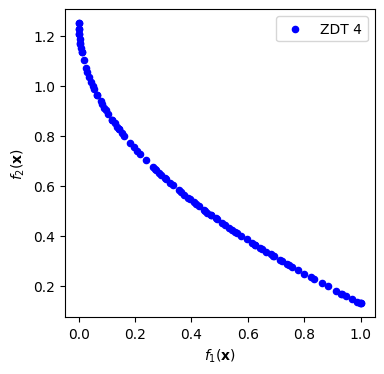

In [93]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 4', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [96]:
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

In [97]:
start_time = time.time()
res, logbook = nsga_iii(toolbox=toolbox,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_zdt4_100_500_2_7.csv', index=False)

gen	evals	std    	min       	avg    	max    	time     
1  	     	30.8788	0.00466992	29.4121	93.5464	0.0180101
2  	     	26.6574	0.00466992	24.7045	93.5464	0.0361869
3  	     	26.6671	0.00466992	23.0093	103.841	0.0480459
4  	     	25.2765	0.00466992	21.0713	88.8471	0.0545633
5  	     	23.6208	0.00466992	19.6445	99.0319	0.0655041
6  	     	18.5004	0.00466992	15.7187	99.0319	0.0735741
7  	     	17.8238	0.00295609	15.8399	42.9282	0.123099 
8  	     	14.0721	0.000938817	11.8777	43.0985	0.129171 
9  	     	14.1077	0.000135217	11.7413	46.5923	0.139741 
10 	     	13.7539	9.81592e-05	11.1395	43.4306	0.153377 
11 	     	13.5046	9.81592e-05	10.6512	43.2586	0.164425 
12 	     	12.1833	9.81592e-05	9.17557	51.7787	0.178214 
13 	     	10.6314	9.34877e-05	8.08981	51.8819	0.190218 
14 	     	9.40398	9.34877e-05	6.62228	51.8819	0.204653 
15 	     	9.0021 	9.34877e-05	6.12244	51.8819	0.217189 
16 	     	8.80667	9.34477e-05	6.31034	51.8819	0.228386 
17 	     	7.32521	9.3447e-05 	5.49956	27.6403	0.241243 


147	     	0.351807	3.14266e-08	0.587093	1.49995	1.98777  
148	     	0.359913	3.14266e-08	0.58838 	1.49995	2.00611  
149	     	0.362155	3.14266e-08	0.59005 	1.49995	2.02022  
150	     	0.338176	3.14266e-08	0.587498	1.49995	2.03172  
151	     	0.3204  	3.14266e-08	0.58636 	1.49995	2.04723  
152	     	0.323176	3.14266e-08	0.586875	1.49995	2.05535  
153	     	0.320528	3.14266e-08	0.587261	1.49995	2.06804  
154	     	0.317367	3.14266e-08	0.587174	1.49995	2.08129  
155	     	0.312911	3.14266e-08	0.586613	1.49994	2.09933  
156	     	0.319833	3.14266e-08	0.586641	1.49994	2.11712  
157	     	0.331498	3.14266e-08	0.58832 	1.49994	2.13259  
158	     	0.347444	3.14266e-08	0.591209	1.49994	2.14777  
159	     	0.343723	3.14266e-08	0.591139	1.49994	2.15812  
160	     	0.340729	3.14266e-08	0.589961	1.49993	2.17308  
161	     	0.335355	3.14266e-08	0.590716	1.49993	2.187    
162	     	0.322288	3.14266e-08	0.590306	1.49993	2.19976  
163	     	0.322166	3.14266e-08	0.591687	1.49993	2.21832  
164	     	0.31

297	     	0.31807 	2.84113e-08	0.589023	1.49919	4.252    
298	     	0.314143	2.84113e-08	0.588335	1.49919	4.26322  
299	     	0.313228	2.84113e-08	0.588324	1.49919	4.27926  
300	     	0.316635	2.84113e-08	0.588153	1.49919	4.29964  
301	     	0.310621	2.84113e-08	0.58872 	1.49919	4.31321  
302	     	0.309407	2.84113e-08	0.588871	1.49919	4.32233  
303	     	0.315231	2.84113e-08	0.589373	1.49919	4.33334  
304	     	0.311686	2.84113e-08	0.589883	1.49919	4.34637  
305	     	0.324337	2.84113e-08	0.592077	1.49919	4.36186  
306	     	0.310643	2.84113e-08	0.58986 	1.49919	4.37899  
307	     	0.325838	7.61311e-09	0.590366	1.49928	4.39153  
308	     	0.323768	7.61311e-09	0.58974 	1.49928	4.40923  
309	     	0.336966	7.61311e-09	0.591508	1.49928	4.42236  
310	     	0.33342 	7.61311e-09	0.590759	1.49928	4.43302  
311	     	0.328464	7.61311e-09	0.58983 	1.49928	4.44898  
312	     	0.328583	7.61311e-09	0.589862	1.49928	4.46321  
313	     	0.328673	7.61311e-09	0.589879	1.49928	4.4777   
314	     	0.32

445	     	0.309783	2.36371e-09	0.589464	1.49931	6.521    
446	     	0.309782	2.36371e-09	0.589464	1.49931	6.533    
447	     	0.309817	2.36371e-09	0.589474	1.49931	6.54341  
448	     	0.309819	2.36371e-09	0.589474	1.49931	6.55637  
449	     	0.309819	2.36371e-09	0.589474	1.49931	6.57163  
450	     	0.30981 	2.36371e-09	0.589472	1.49931	6.58715  
451	     	0.309824	2.36371e-09	0.589478	1.49931	6.59968  
452	     	0.30983 	2.36371e-09	0.589479	1.49931	6.61849  
453	     	0.309806	2.36371e-09	0.589474	1.49931	6.63537  
454	     	0.309809	2.36371e-09	0.589476	1.49931	6.65133  
455	     	0.309805	2.36371e-09	0.589475	1.49931	6.66503  
456	     	0.309806	2.36371e-09	0.589473	1.49931	6.68007  
457	     	0.309806	2.36371e-09	0.589473	1.49931	6.69511  
458	     	0.309804	2.36371e-09	0.589473	1.49931	6.71097  
459	     	0.309791	2.36371e-09	0.58947 	1.49931	6.72539  
460	     	0.309791	2.36371e-09	0.58947 	1.49931	6.73993  
461	     	0.309771	2.36371e-09	0.589464	1.49931	6.75415  
462	     	0.30

In [99]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_zdt4_100_500_2_7.csv', index=False)

## ZDT 5

In [100]:
NDIM = 80

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()
toolbox.register("evaluate", zdt5) #Fitness Function

#Chromosome representation Binary
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, NDIM) #The individual consist of a 35 binary length
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [101]:
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

In [102]:
start_time = time.time()
res, logbook = nsga_ii(toolbox=toolbox, seed=1, stats=stats, verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga2_zdt5_100_500_2_80.csv', index=False)

gen	nevals	avg     	std     	min     	max     	time     
0  	100   	0.389518	0.141693	0.172414	0.724138	0.0592308
1  	100   	0.385404	0.151245	0.162562	0.724138	0.100119 
2  	100   	0.385189	0.170428	0.153605	0.758621	0.135026 
3  	100   	0.37596 	0.161845	0.148903	0.758621	0.185946 
4  	100   	0.37375 	0.177386	0.134796	0.793103	0.219939 
5  	100   	0.371009	0.18696 	0.125   	0.793103	0.265724 
6  	100   	0.360789	0.171995	0.125   	0.793103	0.306616 
7  	100   	0.358837	0.176995	0.125   	0.793103	0.353539 
8  	100   	0.355826	0.176868	0.125   	0.793103	0.386541 
9  	100   	0.35041 	0.171045	0.103448	0.793103	0.438779 
10 	100   	0.349556	0.184461	0.103448	0.922414	0.488681 
11 	100   	0.348107	0.190425	0.102069	0.922414	0.532819 
12 	100   	0.34846 	0.19851 	0.0905172	0.922414	0.580732 
13 	100   	0.351562	0.21324 	0.0905172	0.922414	0.630741 
14 	100   	0.34784 	0.215852	0.0905172	1.02586 	0.680896 
15 	100   	0.341302	0.208762	0.0772414	0.948276	0.738491 
16 	100   	0.348737	0.22823

147	100   	0.542243	0.637329	0        	1.62069 	6.16106  
148	100   	0.542243	0.637329	0        	1.62069 	6.19305  
149	100   	0.542243	0.637329	0        	1.62069 	6.22901  
150	100   	0.542243	0.637329	0        	1.62069 	6.27394  
151	100   	0.542243	0.637329	0        	1.62069 	6.30785  
152	100   	0.542243	0.637329	0        	1.62069 	6.33067  
153	100   	0.542243	0.637329	0        	1.62069 	6.3556   
154	100   	0.542243	0.637329	0        	1.62069 	6.39219  
155	100   	0.542243	0.637329	0        	1.62069 	6.42806  
156	100   	0.542243	0.637329	0        	1.62069 	6.46505  
157	100   	0.542243	0.637329	0        	1.62069 	6.50098  
158	100   	0.542243	0.637329	0        	1.62069 	6.54283  
159	100   	0.542243	0.637329	0        	1.62069 	6.59529  
160	100   	0.542243	0.637329	0        	1.62069 	6.63418  
161	100   	0.542243	0.637329	0        	1.62069 	6.67009  
162	100   	0.542243	0.637329	0        	1.62069 	6.70898  
163	100   	0.542243	0.637329	0        	1.62069 	6.75082  
164	100   	0.5

292	100   	0.542243	0.637329	0        	1.62069 	11.9089  
293	100   	0.542243	0.637329	0        	1.62069 	11.9498  
294	100   	0.542243	0.637329	0        	1.62069 	11.9887  
295	100   	0.542243	0.637329	0        	1.62069 	12.0289  
296	100   	0.542243	0.637329	0        	1.62069 	12.0758  
297	100   	0.542243	0.637329	0        	1.62069 	12.1047  
298	100   	0.542243	0.637329	0        	1.62069 	12.1322  
299	100   	0.542243	0.637329	0        	1.62069 	12.168   
300	100   	0.542243	0.637329	0        	1.62069 	12.201   
301	100   	0.542243	0.637329	0        	1.62069 	12.238   
302	100   	0.542243	0.637329	0        	1.62069 	12.2789  
303	100   	0.542243	0.637329	0        	1.62069 	12.3208  
304	100   	0.542243	0.637329	0        	1.62069 	12.3628  
305	100   	0.542243	0.637329	0        	1.62069 	12.3986  
306	100   	0.542243	0.637329	0        	1.62069 	12.4376  
307	100   	0.542243	0.637329	0        	1.62069 	12.4784  
308	100   	0.542243	0.637329	0        	1.62069 	12.5163  
309	100   	0.5

439	100   	0.542243	0.637329	0        	1.62069 	17.8299  
440	100   	0.542243	0.637329	0        	1.62069 	17.8997  
441	100   	0.542243	0.637329	0        	1.62069 	17.9478  
442	100   	0.542243	0.637329	0        	1.62069 	17.9846  
443	100   	0.542243	0.637329	0        	1.62069 	18.0215  
444	100   	0.542243	0.637329	0        	1.62069 	18.0505  
445	100   	0.542243	0.637329	0        	1.62069 	18.0844  
446	100   	0.542243	0.637329	0        	1.62069 	18.1542  
447	100   	0.542243	0.637329	0        	1.62069 	18.2553  
448	100   	0.542243	0.637329	0        	1.62069 	18.2932  
449	100   	0.542243	0.637329	0        	1.62069 	18.3292  
450	100   	0.542243	0.637329	0        	1.62069 	18.3681  
451	100   	0.542243	0.637329	0        	1.62069 	18.412   
452	100   	0.542243	0.637329	0        	1.62069 	18.446   
453	100   	0.542243	0.637329	0        	1.62069 	18.481   
454	100   	0.542243	0.637329	0        	1.62069 	18.5508  
455	100   	0.542243	0.637329	0        	1.62069 	18.6358  
456	100   	0.5

In [104]:
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_zdt5_100_500_2_80.csv', index=False)

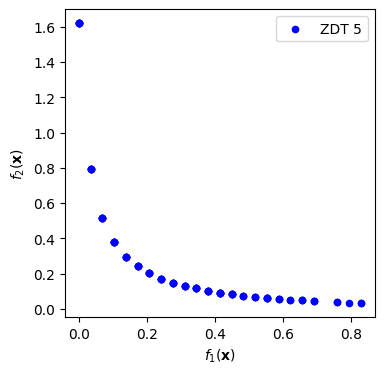

In [42]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 5', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [105]:
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

In [106]:
start_time = time.time()
res, logbook = nsga_iii(toolbox=toolbox,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_zdt5_100_500_2_80.csv', index=False)

gen	evals	std     	min     	avg     	max     	time     
1  	     	0.141209	0.182759	0.391501	0.655172	0.0573533
2  	     	0.147645	0.172414	0.383141	0.689655	0.0892694
3  	     	0.137174	0.172414	0.373266	0.655172	0.123359 
4  	     	0.13409 	0.165948	0.366262	0.689655	0.17382  
5  	     	0.141564	0.16092 	0.36364 	0.689655	0.22424  
6  	     	0.148285	0.152709	0.359185	0.689655	0.249044 
7  	     	0.150096	0.132184	0.353207	0.724138	0.271068 
8  	     	0.146275	0.132184	0.345773	0.724138	0.304713 
9  	     	0.143902	0.12069 	0.339222	0.724138	0.329883 
10 	     	0.14864 	0.108374	0.334902	0.855172	0.352834 
11 	     	0.168134	0.103448	0.336195	1.07759 	0.368377 
12 	     	0.196106	0.103448	0.343268	1.07759 	0.39016  
13 	     	0.207391	0.103448	0.345302	1.07759 	0.421348 
14 	     	0.228482	0.103448	0.35035 	1.07759 	0.449398 
15 	     	0.249029	0.0689655	0.355972	1.07759 	0.466314 
16 	     	0.1999  	0.0689655	0.333286	1.05172 	0.511298 
17 	     	0.184808	0.0689655	0.31902 	1.13793 

150	     	0.289324	0        	0.285229	1.51724 	4.5676   
151	     	0.291559	0        	0.287068	1.51724 	4.60111  
152	     	0.276061	0        	0.281065	1.51724 	4.62504  
153	     	0.279258	0        	0.283214	1.51724 	4.66416  
154	     	0.292477	0        	0.288555	1.51724 	4.69415  
155	     	0.290536	0        	0.286739	1.51724 	4.72904  
156	     	0.294056	0        	0.289857	1.51724 	4.74707  
157	     	0.276551	0        	0.280898	1.51724 	4.77107  
158	     	0.291133	0        	0.287382	1.51724 	4.80363  
159	     	0.29424 	0        	0.289818	1.51724 	4.83062  
160	     	0.291672	0        	0.287194	1.51724 	4.84942  
161	     	0.27843 	0        	0.282508	1.51724 	4.88835  
162	     	0.278927	0        	0.282558	1.51724 	4.93566  
163	     	0.293061	0        	0.288617	1.51724 	4.97107  
164	     	0.292454	0        	0.288051	1.51724 	4.99922  
165	     	0.291459	0        	0.287278	1.51724 	5.02428  
166	     	0.277319	0        	0.281614	1.51724 	5.05618  
167	     	0.288734	0        	0.

294	     	0.299056	0        	0.293186	1.51724 	9.38242  
295	     	0.28698 	0        	0.289146	1.51724 	9.42239  
296	     	0.285303	0        	0.287545	1.51724 	9.45224  
297	     	0.286514	0        	0.28811 	1.51724 	9.48135  
298	     	0.289282	0        	0.290707	1.51724 	9.52296  
299	     	0.286266	0        	0.287847	1.51724 	9.55417  
300	     	0.291475	0        	0.292178	1.51724 	9.59913  
301	     	0.289189	0        	0.290148	1.51724 	9.63598  
302	     	0.290064	0        	0.291134	1.51724 	9.6726   
303	     	0.290057	0        	0.290917	1.51724 	9.70323  
304	     	0.300612	0        	0.294014	1.51724 	9.737    
305	     	0.30411 	0        	0.297239	1.51724 	9.76862  
306	     	0.287475	0        	0.288839	1.51724 	9.80474  
307	     	0.291867	0        	0.292211	1.51724 	9.84922  
308	     	0.286163	0        	0.287699	1.51724 	9.88841  
309	     	0.30208 	0        	0.295007	1.51724 	9.93745  
310	     	0.301635	0        	0.295093	1.51724 	9.97565  
311	     	0.288911	0        	0.

442	     	0.287333	0        	0.288737	1.51724 	14.5253  
443	     	0.288547	0        	0.290084	1.51724 	14.5492  
444	     	0.301419	0        	0.294987	1.51724 	14.5793  
445	     	0.301049	0        	0.294682	1.51724 	14.6181  
446	     	0.290463	0        	0.291685	1.51724 	14.6451  
447	     	0.302574	0        	0.296554	1.51724 	14.67    
448	     	0.290565	0        	0.291592	1.51724 	14.7063  
449	     	0.291322	0        	0.292047	1.51724 	14.739   
450	     	0.287577	0        	0.288892	1.51724 	14.7708  
451	     	0.302305	0        	0.295651	1.51724 	14.8109  
452	     	0.288312	0        	0.289608	1.51724 	14.8484  
453	     	0.302219	0        	0.295681	1.51724 	14.8741  
454	     	0.294256	0        	0.294303	1.51724 	14.9026  
455	     	0.301723	0        	0.295222	1.51724 	14.9365  
456	     	0.304564	0        	0.297715	1.51724 	14.9702  
457	     	0.28777 	0        	0.289761	1.51724 	15.0002  
458	     	0.291084	0        	0.291931	1.51724 	15.0388  
459	     	0.299268	0        	0.

In [108]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_zdt5_100_500_2_80.csv', index=False)

## ZDT 6

In [109]:
NDIM = 10

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", zdt6) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [111]:
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

In [112]:
start_time = time.time()
res, logbook = nsga_ii(toolbox=toolbox, seed=1, stats=stats, verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga2_zdt6_100_500_2_10.csv', index=False)

gen	nevals	avg    	std    	min     	max    	time      
0  	100   	4.69306	3.81225	0.280912	9.46916	0.00401115
1  	100   	4.54823	3.7473 	0.2808  	8.98219	0.12997   
2  	100   	4.41607	3.72519	0.280775	9.1847 	0.262073  
3  	100   	4.30426	3.67062	0.280775	8.79122	0.412299  
4  	100   	4.18931	3.6318 	0.280775	8.50066	0.517853  
5  	100   	4.08986	3.51602	0.280775	8.37949	0.612904  
6  	100   	4.00005	3.48408	0.280775	8.18307	0.731803  
7  	100   	3.93043	3.40502	0.280775	8.03844	0.814267  
8  	100   	3.83229	3.34474	0.280775	7.68009	0.93419   
9  	100   	3.74737	3.28912	0.280775	7.64003	1.05299   
10 	100   	3.68499	3.23394	0.280775	7.59962	1.14012   
11 	100   	3.60585	3.2066 	0.280775	7.59962	1.22514   
12 	100   	3.54672	3.11823	0.280775	7.5142 	1.35963   
13 	100   	3.44892	3.06077	0.280775	7.48023	1.45238   
14 	100   	3.37031	2.99219	0.280775	7.31725	1.54187   
15 	100   	3.28805	2.90209	0.280775	7.04071	1.62195   
16 	100   	3.25028	2.85855	0.280775	7.12381	1.70724   
17 	100   

149	100   	0.814408	0.260545	0.280775	1.34208	13.0568   
150	100   	0.809743	0.252119	0.280775	1.34208	13.1294   
151	100   	0.803119	0.249556	0.280775	1.29826	13.1921   
152	100   	0.797917	0.255557	0.280775	1.28639	13.301    
153	100   	0.796696	0.250359	0.280775	1.28639	13.3811   
154	100   	0.792745	0.255382	0.280775	1.28639	13.461    
155	100   	0.790041	0.252222	0.280775	1.2845 	13.5456   
156	100   	0.786393	0.261994	0.280775	1.2845 	13.6224   
157	100   	0.780268	0.26521 	0.280775	1.2845 	13.7068   
158	100   	0.775842	0.271977	0.280775	1.27763	13.778    
159	100   	0.772826	0.265969	0.280775	1.27763	13.8567   
160	100   	0.767552	0.282939	0.280775	1.27763	13.93     
161	100   	0.767039	0.251039	0.280775	1.27763	14.0249   
162	100   	0.761923	0.236735	0.280775	1.27264	14.112    
163	100   	0.753079	0.228535	0.280775	1.17315	14.2032   
164	100   	0.747914	0.235083	0.280775	1.17219	14.3113   
165	100   	0.744111	0.226089	0.280775	1.17219	14.3921   
166	100   	0.739863	0.228557	0.

292	100   	0.60457 	0.256181	0.0481098	1       	25.0299   
293	100   	0.604263	0.254205	0.0468059	1       	25.1108   
294	100   	0.606401	0.248624	0.0468059	1       	25.2001   
295	100   	0.605582	0.250736	0.0468059	1       	25.2973   
296	100   	0.605702	0.249397	0.0468059	1       	25.3831   
297	100   	0.606735	0.243446	0.0468059	1       	25.4713   
298	100   	0.60606 	0.24728 	0.0468059	1       	25.5697   
299	100   	0.605127	0.250911	0.0468059	1       	25.6529   
300	100   	0.604347	0.250789	0.0457762	1       	25.732    
301	100   	0.60537 	0.247071	0.0457762	1       	25.8028   
302	100   	0.604453	0.252206	0.0457762	1       	25.8744   
303	100   	0.602638	0.256897	0.0390701	1       	25.9431   
304	100   	0.603362	0.252119	0.0390701	1       	25.993    
305	100   	0.602373	0.251454	0.0362156	1       	26.0636   
306	100   	0.602352	0.255581	0.0359869	1       	26.132    
307	100   	0.603439	0.248912	0.0359869	1       	26.2241   
308	100   	0.603477	0.250231	0.0359869	1       	26.3049 

431	100   	0.592244	0.254981	0.00856978	1       	36.3431   
432	100   	0.590129	0.259271	0.00856978	1       	36.4224   
433	100   	0.588714	0.26075 	0.00856978	1       	36.5011   
434	100   	0.590446	0.257606	0.00856978	1       	36.5778   
435	100   	0.588159	0.269077	0.00856978	1       	36.642    
436	100   	0.593028	0.250006	0.00856978	1       	36.7164   
437	100   	0.594636	0.246752	0.00855651	1       	36.8083   
438	100   	0.593514	0.250197	0.00855651	1       	36.892    
439	100   	0.594567	0.245119	0.00855651	1       	36.9671   
440	100   	0.592684	0.248469	0.00855651	1       	37.0388   
441	100   	0.59072 	0.256981	0.00855651	1       	37.1065   
442	100   	0.590533	0.261018	0.00787294	1       	37.1809   
443	100   	0.592629	0.254054	0.00787294	1       	37.2528   
444	100   	0.588692	0.26869 	0.00787294	1       	37.3307   
445	100   	0.59232 	0.254787	0.00787294	1       	37.4119   
446	100   	0.592043	0.255263	0.00787294	1       	37.4819   
447	100   	0.593786	0.24987 	0.00787294	

In [114]:
# logbook
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_zdt6_100_500_2_10.csv', index=False)

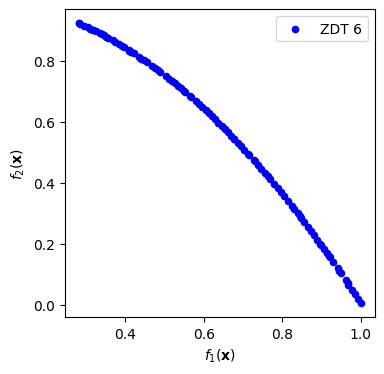

In [51]:
plot_colors = ('b','r', 'g', 'm', 'y', 'k', 'c')
fig, ax = plt.subplots(1, figsize=(4,4))

df.plot(ax=ax, kind='scatter', label='ZDT 6', 
        x=df.columns[0], y=df.columns[1], 
        color=plot_colors[i % len(plot_colors)])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

In [115]:
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

In [116]:
start_time = time.time()
res, logbook = nsga_iii(toolbox=toolbox,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_zdt6_100_500_2_10.csv', index=False)

gen	evals	std    	min   	avg    	max    	time     
1  	     	3.79155	0.3431	4.69831	9.30527	0.0146928
2  	     	3.69762	0.3431	4.54712	9.03069	0.0324717
3  	     	3.66223	0.3431	4.43811	8.91487	0.0441136
4  	     	3.63813	0.287001	4.34206	8.77415	0.0628638
5  	     	3.55373	0.287001	4.23535	8.41757	0.0822012
6  	     	3.51984	0.287001	4.13419	8.55534	0.0952845
7  	     	3.47241	0.287001	4.03913	8.55534	0.102784 
8  	     	3.35405	0.287001	3.93088	7.9086 	0.128046 
9  	     	3.17486	0.285959	3.79316	8.05704	0.133285 
10 	     	3.12166	0.285959	3.69464	8.05704	0.152009 
11 	     	3.0072 	0.285959	3.59217	8.05704	0.162076 
12 	     	2.96166	0.285959	3.5095 	8.10301	0.176008 
13 	     	2.91214	0.285504	3.44347	8.05704	0.189893 
14 	     	2.76292	0.285491	3.32684	6.90651	0.210419 
15 	     	2.78961	0.285486	3.30769	6.85163	0.222798 
16 	     	2.76418	0.285486	3.26154	6.85214	0.250214 
17 	     	2.69784	0.284615	3.18905	6.85214	0.269686 
18 	     	2.60104	0.284615	3.12273	6.70351	0.282163 
1

162	     	0.323063	0.280775	0.793414	1.29667	2.46979  
163	     	0.340974	0.280775	0.790151	1.29667	2.48798  
164	     	0.303135	0.280775	0.788385	1.29667	2.50285  
165	     	0.331626	0.280775	0.788412	1.29667	2.53204  
166	     	0.352747	0.280775	0.787403	1.29667	2.55304  
167	     	0.232905	0.280775	0.784851	1.29667	2.56286  
168	     	0.25322 	0.280775	0.777938	1.29663	2.5814   
169	     	0.289228	0.280775	0.7725  	1.29663	2.59605  
170	     	0.279843	0.280775	0.770216	1.29663	2.6029   
171	     	0.307647	0.280775	0.768246	1.29663	2.61223  
172	     	0.314518	0.280775	0.76518 	1.29663	2.63238  
173	     	0.295322	0.280775	0.768545	1.29663	2.64383  
174	     	0.310215	0.280775	0.765599	1.29663	2.65921  
175	     	0.241332	0.280775	0.760139	1.28461	2.66986  
176	     	0.24296 	0.280775	0.75793 	1.24758	2.68692  
177	     	0.270903	0.280775	0.757063	1.24758	2.70119  
178	     	0.273095	0.280775	0.751939	1.24758	2.72084  
179	     	0.270989	0.280775	0.747271	1.24758	2.73203  
180	     	

311	     	0.246755	0.0560228	0.614001	0.999982	4.98338  
312	     	0.248322	0.0560228	0.612111	0.999982	5.00223  
313	     	0.251901	0.0560228	0.612228	0.999982	5.01864  
314	     	0.242037	0.0560228	0.614372	0.999982	5.0429   
315	     	0.25001 	0.0560214	0.611324	0.999997	5.05637  
316	     	0.244228	0.0560214	0.613177	0.999997	5.08749  
317	     	0.251367	0.0560214	0.611555	0.999997	5.10985  
318	     	0.24158 	0.0560214	0.61292 	0.999997	5.12479  
319	     	0.243389	0.0515267	0.61243 	0.999944	5.13313  
320	     	0.244256	0.0495886	0.612413	0.999944	5.15285  
321	     	0.246631	0.0479309	0.611897	0.999944	5.17119  
322	     	0.249717	0.0479309	0.611258	0.999944	5.18335  
323	     	0.245472	0.0479309	0.611244	0.999944	5.20264  
324	     	0.248102	0.0479309	0.611051	0.999944	5.21881  
325	     	0.247262	0.0479309	0.611092	0.999944	5.23288  
326	     	0.244621	0.0479309	0.611622	0.999944	5.25116  
327	     	0.247247	0.0479309	0.610918	0.999944	5.28311  
328	     	0.250035	0.0479309	0.

459	     	0.244996	0.0107752	0.599762	0.999991	7.72225  
460	     	0.248764	0.0107752	0.598334	0.999991	7.73729  
461	     	0.250506	0.0107752	0.598619	0.999991	7.75368  
462	     	0.252871	0.0107752	0.598036	0.999991	7.77706  
463	     	0.251501	0.0107752	0.59809 	0.999991	7.80234  
464	     	0.246924	0.0107752	0.599133	0.999991	7.83203  
465	     	0.248792	0.0107752	0.599088	0.999991	7.85283  
466	     	0.24971 	0.0107752	0.598878	0.999991	7.86198  
467	     	0.250516	0.0101532	0.598232	0.999967	7.89531  
468	     	0.248705	0.0101532	0.598577	0.999967	7.91436  
469	     	0.247726	0.0101532	0.598868	0.999967	7.93191  
470	     	0.248578	0.0101532	0.598525	0.999967	7.96248  
471	     	0.247626	0.0101532	0.59885 	0.999967	8.01461  
472	     	0.248129	0.0101532	0.598897	0.999967	8.03995  
473	     	0.248179	0.0101532	0.598535	0.999967	8.05299  
474	     	0.248626	0.00969866	0.59878 	0.999969	8.06309  
475	     	0.248729	0.00969866	0.598745	0.999969	8.08281  
476	     	0.252519	0.00959833

In [118]:
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_zdt6_100_500_2_10.csv', index=False)